<a href="https://colab.research.google.com/github/khalidpark/whitepaper-DeepLearning/blob/main/deep_learning_whitepapaer_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ⛏ 텍스트에서 특성들을 추출하고 문서 분류기를 만들어 보겠습니다.

Sklearn 파이프라인을 사용하면 머신러닝 프로세스에 사용되는 여러 컴포넌트들을 쉽게 연결할 수 있었습니다.

이번에는 파이프라인을 이용해 코퍼스 입력, 차원 축소, 학습 프로세스를 진행해 보겠습니다.

벡터화 과정중에 n-gram 범위, 최대 토큰의 수 같은 하이퍼파라미터들을 수정해 가며 실험을 해 보아야 합니다.

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_20newsgroups #뉴스그룹 문서 데이터셋
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

20개 뉴스그룹으로 분류된 18,000개의 뉴스그룹 문서 데이터셋 입니다.
- [20newsgroups](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups)
- 전자와 정치에 관한 두 개의 다른 카테고리 뉴스를 가져오겠습니다.


In [2]:
categories = ['sci.electronics',
              'talk.politics.misc']

ng_train = fetch_20newsgroups(subset='train'
                             , remove=('headers', 'footers', 'quotes')
                             , categories=categories
                             )

ng_test = fetch_20newsgroups(subset='test'
                             , remove=('headers', 'footers', 'quotes')
                             , categories=categories
                             )

학습, 테스트 데이터가 분리되어 있습니다.

In [3]:
len(ng_train.data), len(ng_test.data)

(1056, 703)

한 문서를 확인해 보겠습니다.

In [4]:
ng_train.data[5]

"\nMight be a good idea...  The resolution you requested is about 0.3mV\nIn order to get what you've paid for, noise level better be lower than\nthat.  It is kind of hard to do it in a noisy box like you can expect\ninside a PC.\n\nBefore you pay $$$ for a PC card, test it out by sampling a low\ndistortion sine wave (I think there is a sine wave on a CD.  Digital\nDomain ?  There are possibly other low THD sources)  Run the digitized\nwaveform through a FFT transform and take alook at the noise floor on\nthe spectrum.  That's should give you a good indication of the design.\n(That's what I am doing to test a data acquistion system I have designed\n- I got the idea from MAXIM data sheet.)\n\nIf you can live with 14 bit resolution, I would recommend looking at\nthe MAX121 from MAXIM.  It is a high speed (308KHz) complete\nsampling A/D with DSP interface.  The input range is +/- 5V and it\nuses a serial interface (which can easily be optically isolated\nfrom the computer to elinimate a ma

이 문서의 타겟 레이블 입니다

In [5]:
ng_train.target[5]

0

In [6]:
ng_train.target_names

['sci.electronics', 'talk.politics.misc']



---



### 데이터를 살펴봅시다
- [Step 1: Gather Data](https://developers.google.com/machine-learning/guides/text-classification/step-1)

- [Step 2: Explore Your Data](https://developers.google.com/machine-learning/guides/text-classification/step-2)

학습 모델을 만드는 일은 데이터 분석 과정 중 한 부분입니다. 

모델링 전 데이터의 특성을 확인하고 이해하는 과정을 통해 더욱 좋은 모델을 만들 수 있게 됩니다. 

데이터를 미리 잘 살펴보면 더 적은 데이터로 더 높은 성능을 가진 모델을 만들 수도 있습니다.

- [explore_data.py](https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/explore_data.py) 파일은 ipynb 폴더에 다운받아 import 하여 사용하세요

- [Direct Download Link](https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/etc/explore_data.py)



In [7]:
from google.colab import files

uploaded = files.upload()

for filename in uploaded.keys():
    print(uploaded[filename])

Saving explore_data.py to explore_data.py
b'"""Module to explore data.\nContains functions to help study, visualize and understand datasets.\n"""\nfrom __future__ import absolute_import\nfrom __future__ import division\nfrom __future__ import print_function\n\nimport numpy as np\nimport matplotlib.pyplot as plt\n\nfrom collections import Counter\nfrom sklearn.feature_extraction.text import CountVectorizer\n\n\ndef get_num_classes(labels):\n    """Gets the total number of classes.\n    # Arguments\n        labels: list, label values.\n            There should be at lease one sample for values in the\n            range (0, num_classes -1)\n    # Returns\n        int, total number of classes.\n    # Raises\n        ValueError: if any label value in the range(0, num_classes - 1)\n            is missing or if number of classes is <= 1.\n    """\n    num_classes = max(labels) + 1\n    missing_classes = [i for i in range(num_classes) if i not in labels]\n    if len(missing_classes):\n        

In [8]:
# 그냥 실핼하면 에러가 날 수 있습니다. 
# 위 'Direct Download Link'에서 explore_data를 다운받은 뒤 업로드해서 사용합니다. 
import explore_data as ed
import seaborn as sns

In [9]:
# Gets the median number of words per sample given corpus.
median_words_per_sample = ed.get_num_words_per_sample(ng_train.data)
print('Median words per sample: ', median_words_per_sample)

Median words per sample:  91.0


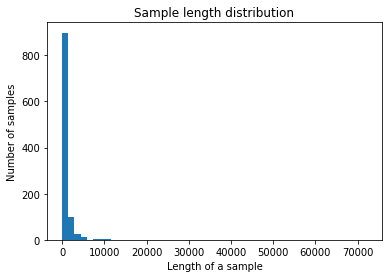

In [10]:
# 데이터 길이 확인
ed.plot_sample_length_distribution(ng_train.data)

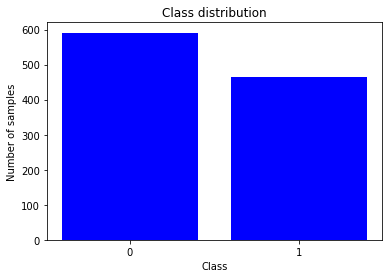

In [11]:
# 전자와 정치 두 카테고리 확인
ed.plot_class_distribution(ng_train.target)

In [12]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [15, 4]

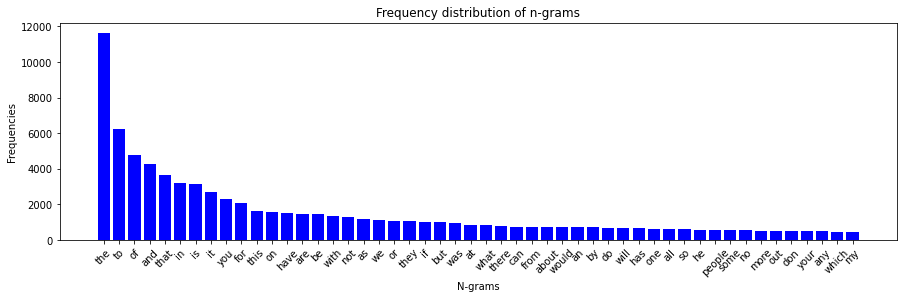

In [13]:
# Plots the frequency distribution of n-grams.
ed.plot_frequency_distribution_of_ngrams(ng_train.data
                                     , ngram_range=(1, 2)
                                     , num_ngrams=50)



---



### 모델은 어떻게 선택할까요? 
- [Step 2.5: Choose a Model](https://developers.google.com/machine-learning/guides/text-classification/step-2-5)

앞서 간단히 살펴본 데이터의 수치를 기반해서 2.5단계에서는 어떤 분류 모델을 사용할 것인지 선택을 해 보겠습니다.

다음 플로우차트에서 어떻게 분류 모델을 선택해야 하는지 구글에서 수행한 여러 실험 결과를 가지고 간략한 가이드를 제공합니다. 목표는 주어진 데이터세트에서 가능한 최선의 정확도를 낼 수 있고 동시에 학습계산량을 줄이는 것이었습니다. 최적의 방법을 찾기 위해 감성분석, 토픽 분류 등 여러 문제들에 대한 12개의 데이터 세트를 사용했으며 또한 여러 학습 모델구조를 사용해 45만번 이상의 실험을 수행하였습니다.

![flowchart](https://developers.google.com/machine-learning/guides/text-classification/images/TextClassificationFlowchart.png)

In [14]:
# 데이터 출처... 
# categories = ['sci.electronics',
#               'talk.politics.misc']

# ng_train = fetch_20newsgroups(subset='train'
#                              , remove=('headers', 'footers', 'quotes')
#                              , categories=categories
#                              )

# ng_test = fetch_20newsgroups(subset='test'
#                              , remove=('headers', 'footers', 'quotes')
#                              , categories=categories
#                              )

# S/W ratio를 계산해 봅시다, 구글 flowchar에 따르면,
# S/W < 1500 일 경우 BoW 를 사용해 벡터화 하고 simple MLP 모델 or 앙상블 모델을 사용하는것을 추천하고 있습니다.
sw_ratio = len(ng_train.data) / median_words_per_sample
print('number of samples / median words per sample ratio: ', int(sw_ratio))

number of samples / median words per sample ratio:  11


### TF-IDF 모델로 베이스라인을 만들어 봅시다

In [15]:
# 파이프라인 구성 요소를 만듭니다
vect = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
rfc = RandomForestClassifier()

In [16]:
import pandas as pd

# DTM을 생성합니다.
# fit_transform : Learn vocabulary and idf, return document-term matrix.
dtm = vect.fit_transform(ng_train.data) 

dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm.shape

(1056, 97372)

In [17]:
# 파이프라인을 정의합니다
pipe = Pipeline([
    ('vect',vect)
    ,('clf', rfc)
])
pipe

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patte...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [18]:
# 파라미터 셋팅
parameters = {
    'vect__max_df': (0.7, 1.0) # document frequency(%) 높을 경우 제거
    ,'vect__min_df': (2, 5, 10) # document frequency(횟수) 낮을 경우 제거
    ,'vect__max_features': (5000, 20000) # 코퍼스에서 term frequency 높은 순서대로 나열하여 제한
    ,'clf__n_estimators': (100, 500) # The number of trees in the forest.
    ,'clf__max_depth': (10, 20, None) # The maximum depth of the tree
}

grid_search = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(ng_train.data, ng_train.target)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  6.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 2),
                                                        no

In [19]:
grid_search.best_score_

0.9052982205132791

In [20]:
grid_search.best_params_

{'clf__max_depth': None,
 'clf__n_estimators': 500,
 'vect__max_df': 1.0,
 'vect__max_features': 20000,
 'vect__min_df': 2}

In [21]:
from sklearn.metrics import accuracy_score

# 테스트 데이터에 대해 정확도를 구해보겠습니다
y_test = grid_search.predict(ng_test.data)
accuracy_score(ng_test.target, y_test)

0.89900426742532

---

## 잠재의미분석(Latent Semantic Analysis, LSA)


잠재의미분석(LSA)는 Word2Vec, BoW 등의 방법론을 사용해 만든 문서-단어행렬(DTM) 데이터의 차원을 축소해 문서들에 숨어있는(latent) 의미(Topics)를 끌어내는 방법입니다.

이때 차원 축소에는 Truncated SVD(특이값 분해)를 사용해 원하는 문서나, 단어의 차원을 축소합니다.

물론 차원이 축소가 되더라도 기존에 문서나, 단어들 간의 거리관계는 어느정도 보존이 됩니다.


<img src="https://www.researchgate.net/profile/Konstantinos_Bougiatiotis/publication/321025221/figure/fig9/AS:668660309962763@1536432449448/Singular-value-decomposition-followed-by-rank-lowering-for-latent-semantic-indexing.jpg" alt="Singular value decomposition followed by rank lowering for latent semantic indexing"/>

SVD를 사용해 행렬 $A$를 $U, Σ, V^{T}$ 세 행렬의 곱으로 분해(decomposion) 합니다.

> $A=UΣV^{T}$

여기서 $U$, $V$가 직교행렬(orthogonal matrix) 이고, $Σ$는 대각행렬로 대각성분이 특이값(singular value)입니다.

$U$, $V$가 직교행렬(orthogonal matrix)일 때 $UU^T=U^TU=I$, $VV^T=V^TV=I$ 관계가 성립하므로

> $AV=UΣ$  입니다

$U$ 와 $V^T$ 의 열 벡터는 특이벡터(singular vector)라 불리는데

Truncated SVD는 특이값(singular value, $Σ$ 대각성분) 가운데 가장 큰 k개만 남기고 해당 특이값에 대응하는 특이벡터들로 원래 행렬 A를 근사하는 방법입니다.

물론 0보다 큰 특이값을 제거하면 정보의 손실이 발생하므로 적당히 필요한 차원만큼 k를 선택합니다.

다음 그림에서 k값 선택에 따른 정보 손실을 확인할 수 있습니다.

<img src="https://i.imgur.com/Dica82I.png" width="600" />


행렬은 선형변환으로 볼 수 있으므로, $V$의 열벡터들을 $A$를 통해 선형변환하면 $Σ$의 특이값 만큼 크기가 변하면서 여전히 직교하는 $U$의 열벡터들을 얻을 수 있다는 것입니다.


여기서 만약 m개 문서, n개 단어로 이루어진 행렬을 truncated SVD로 분해해 다음과 같은 분해를 수행 했다면 다음과 같은 근사 식을 얻을 것이며

$$A_k=U_kΣ_kV^{T}_k$$

$U_k$와 $V_k$를 사용해 n차원으로 표현 되었던 문서를 k차원으로, 또는 m 차원으로 표현되었던 단어를 k 차원으로 표현할 수 있게 됩니다.




---



#### TruncatedSVD 를 사용하여 파이프라인에서 차원을 축소하고 분류문제를 풀어보겠습니다.

In [22]:
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

# SVD를 사용한 차원 축소
from sklearn.decomposition import TruncatedSVD

vect = TfidfVectorizer(stop_words='english'
                       , ngram_range=(1,2)
                       , min_df=2
                       , max_df=0.7
                       , token_pattern=r'(?u)\b\w[A-Za-z]+\b' # 영문자만 사용
                       , max_features=10000
                      )

svd = TruncatedSVD(algorithm='randomized'
                   , n_iter=5
                   , random_state=2)

rfc = RandomForestClassifier(n_estimators=500, random_state=2)

In [23]:
params = {
    # 100~500 사이의 정수 크기로 차원을 줄입니다
#     'svd__n_components': stats.randint(100, 500)
    'svd__n_components': stats.randint(2, 3) # 문서의 차원을 2로 고정
    
}

In [24]:
# 1.Tfidf 문서 벡터화, 2. svd 차원축소, 3. 랜덤포레스트 분류기
pipe = Pipeline([
    ('vect', vect)
    , ('svd', svd)
    , ('clf', rfc)
])

In [25]:
# Fit
random_search = RandomizedSearchCV(pipe,params, cv=3, n_iter=5, n_jobs=-1, verbose=1)
random_search.fit(ng_train.data, ng_train.target)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   15.6s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=0.7,
                                                              max_features=10000,
                                                              min_df=2,
                                                       

In [26]:
# svd__n_components: Random search에서 선택된 줄어든 차원을 확인할 수 있습니다.
random_search.best_params_

{'svd__n_components': 2}

In [27]:
random_search.best_score_

0.9147727272727272

In [28]:
# 테스트셋으로 정확도를 계산합니다
y_test = random_search.predict(ng_test.data)
accuracy_score(ng_test.target, y_test)

0.9075391180654339

In [29]:
from sklearn.metrics import classification_report

print(classification_report(ng_test.target, y_test))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       393
           1       0.91      0.88      0.89       310

    accuracy                           0.91       703
   macro avg       0.91      0.90      0.91       703
weighted avg       0.91      0.91      0.91       703





---



#### SVD를 따로 수행해서 행렬분해가 어떻게 되는지 확인해 보겠습니다.

- randomized_svd를 사용해서 $U$, $\Sigma$, $V^T$ 행렬을 구해보겠습니다.
- randomized_svd는 Truncated SVD에서 내부적으로 사용되는 기능입니다.

In [30]:
# 학습 데이터를 TF-IDF vectorizer로 벡터화하여 사용하겠습니다.
A = random_search.best_estimator_.named_steps['vect'].transform(ng_train.data).todense()
X_test = random_search.best_estimator_.named_steps['vect'].transform(ng_test.data).todense()

In [31]:
# DTM
A.shape, X_test.shape

((1056, 10000), (703, 10000))

In [32]:
# randomized_svd를 사용하여 U, S(Sigma), VT(V transposed) 행렬을 얻습니다
from sklearn.utils.extmath import randomized_svd

U, S, VT = randomized_svd(A
                         , n_components=2 # 상위 특이값 2개를 선택합니다
                         , n_iter=5
                         , random_state=2)

In [33]:
U.shape, S.shape, VT.shape

((1056, 2), (2,), (2, 10000))

In [34]:
U

array([[ 0.02975338,  0.02040102],
       [ 0.0290698 ,  0.04117074],
       [ 0.03961388, -0.04253567],
       ...,
       [ 0.03970262, -0.01638489],
       [ 0.03398986,  0.03985268],
       [ 0.01414231, -0.01261801]])

In [35]:
# 대각 성분(특이값)만 가져왔습니다.
S

array([3.92178091, 2.59248335])

In [36]:
VT

array([[ 0.00103713,  0.00276685,  0.00616488, ...,  0.00451874,
         0.00629204,  0.0035681 ],
       [ 0.00127521,  0.00616524,  0.01354243, ...,  0.00637487,
         0.00368002, -0.00077783]])

$V_k^{T} V_k = I_k$

In [37]:
VT @ VT.T

array([[ 1.00000000e+00, -3.46944695e-18],
       [-3.46944695e-18,  1.00000000e+00]])

$A_k=U_kΣ_kV^{T}_k$ 

=> $A_k V_k = U_k\Sigma_k$

In [38]:
# A는 A_k는 아니지만 결과는 같습니다.
AV = A @ VT.T
AV

matrix([[ 0.11668625,  0.0528893 ],
        [ 0.11400537,  0.10673446],
        [ 0.15535694, -0.11027301],
        ...,
        [ 0.15570497, -0.04247756],
        [ 0.1333008 ,  0.10331742],
        [ 0.05546305, -0.03271198]])

In [39]:
US = U @ np.diag(S)
US

array([[ 0.11668625,  0.0528893 ],
       [ 0.11400537,  0.10673446],
       [ 0.15535694, -0.11027301],
       ...,
       [ 0.15570497, -0.04247756],
       [ 0.1333008 ,  0.10331742],
       [ 0.05546305, -0.03271198]])

테스트 문서들도 $V_k$를 사용해서 문서의 차원을 축소할 수 있습니다.

$XV_k$

In [40]:
X_test_trans = X_test @ VT.T
X_test_trans

matrix([[ 0.03407879, -0.03776464],
        [ 0.14614089, -0.05216358],
        [ 0.0676408 ,  0.07027432],
        ...,
        [ 0.14372308,  0.06976893],
        [ 0.09377234,  0.04664435],
        [ 0.10378836, -0.04427015]])

In [41]:
X_test_trans.shape

(703, 2)

#### truncatedSVD 결과물로 비교해 보겠습니다.

truncatedSVD 속성 `components_` 가 행렬 VT입니다.

In [42]:
components = random_search.best_estimator_.named_steps['svd'].components_
print((components - VT).sum())

-2.582271366323479e-15


TruncatedSVD 속성을 조금 더 살펴봅시다.

먼저 특이값를 확인해 보겠습니다. 위에서 구한 S(Sigma)와 같습니다.

In [43]:
components[:10].shape

(2, 10000)

In [44]:
print(random_search.best_estimator_.named_steps['svd'].singular_values_)
print(S)

[3.92178091 2.59248335]
[3.92178091 2.59248335]


차원이 줄어든 데이터(AV, US)의 분산값입니다.  

In [45]:
print(random_search.best_estimator_.named_steps['svd'].explained_variance_)
print(np.var(US, axis=0))

[0.00302819 0.00629697]
[0.00302819 0.00629697]


이번에는 테스트 문서 샘플을 SVD를 사용해 차원 축소해 보겠습니다.

In [46]:
# 예시로 테스트 문서 0 벡터를 사용합니다.
d0 = X_test[0]
print(d0.shape)
print(random_search.best_estimator_.named_steps['svd'].transform(d0))

(1, 10000)
[[ 0.03407879 -0.03776464]]


테스트 데이터를 모두 변환해 보겠습니다.

In [47]:
print(X_test.shape)
X_test_trans_2 = random_search.best_estimator_.named_steps['svd'].transform(X_test)
print(X_test_trans_2.shape)

(703, 10000)
(703, 2)


위에서 직접 구한 값과 같습니다. (X_test @ VT.T)

In [48]:
# 문서 0만 보겠습니다.
X_test_trans[0], X_test_trans_2[0]

(matrix([[ 0.03407879, -0.03776464]]), array([ 0.03407879, -0.03776464]))



---



#### LSA는 SVD를 통해 찾아진 topic들을 가지고 문서와, 단어의 잠재적인 의미를 분석하는 것 입니다.

각 차원에 어떤 단어들이 모여 있는지 확인해 봅시다.
SVD를 통해 찾아진 두 잠재적 의미군(토픽)에 속하는 단어들을 확인할 수 있습니다.

In [49]:
# terms: 벡터화한 단어
terms = random_search.best_estimator_.named_steps['vect'].get_feature_names()
for index, topic in enumerate(components[:10]): # topic 최대 10개만 표시, 지금은 k가 2이므로 토픽 2개 다 프린트)
    print('Topic %d: '%(index + 1), [terms[i] for i in topic.argsort()[::-1][:6]]) # 토픽에 가장 큰게 기여한 단어부터 최대 6단어 표시
    print('Score %d: '%(index + 1), [topic[i] for i in topic.argsort()[::-1][:6]]) # 단어 스코어

Topic 1:  ['people', 'don', 'like', 'know', 'just', 'think']
Score 1:  [0.1812089691771802, 0.1480755846368723, 0.14591065367394312, 0.1395040623730916, 0.13370844711918825, 0.1236837187427575]
Topic 2:  ['thanks', 'output', 'ingr', 'dtmedin', 'catbyte', 'circuit']
Score 2:  [0.12865724561119146, 0.11374062140626552, 0.10726694807306968, 0.10726694807306968, 0.10726694807306968, 0.10172948540074012]


#### MLP(Multi-layer perceptron classifier)를 간단히 사용해보겠습니다

In [50]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs'
                   , alpha=1e-5
                   , hidden_layer_sizes=(16,2)
                   , random_state=2
                   )

In [51]:
# 1.Tfidf 문서 벡터화, 2. svd 차원축소, 3. 랜덤포레스트 분류기
pipe = Pipeline([
    ('vect', vect)
    , ('svd', svd)
    , ('clf', clf)
])

In [52]:
# Fit
random_search = RandomizedSearchCV(pipe,params, cv=3, n_iter=5, n_jobs=-1, verbose=1)
random_search.fit(ng_train.data, ng_train.target)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.6s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=0.7,
                                                              max_features=10000,
                                                              min_df=2,
                                                       

In [53]:
# 테스트셋으로 정확도를 계산합니다
y_test = random_search.predict(ng_test.data)
accuracy_score(ng_test.target, y_test)

0.9246088193456614

In [54]:
from sklearn.metrics import classification_report

print(classification_report(ng_test.target, y_test))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       393
           1       0.94      0.89      0.91       310

    accuracy                           0.92       703
   macro avg       0.93      0.92      0.92       703
weighted avg       0.93      0.92      0.92       703



In [56]:
clf.get_params()

{'activation': 'relu',
 'alpha': 1e-05,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (16, 2),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 2,
 'shuffle': True,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}